# Tukey depth eikonal equation on N-dimensional graphs

In this notebook, we are interested to solve, for any $d\geq 2$,
$$ |\nabla u(x)| - \int_{(y-x) \cdot \nabla u(x) } \rho(y) dS(y) = 0, \quad  x \in \mathbb{R}^d$$
where $\rho$ is the given data density. The viscosity solution of the PDE $u$ will represent the Tukey depth measure of $\rho$. If $\rho$ is a probability measure, then $x$ such that $u(x) = 0.5$ will be the median of $\rho$.

In [1]:
count = 0

In [2]:
import os
if count==0:
    os.chdir('../')
    count = 1
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
building 'MonotoneScheme' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -DVERSION_INFO=0.0.12 -Isrc/ -I/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pybind11/include -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c src/main.cpp -o build/temp.macosx-10.9-x86_64-3.6/src/main.o -std=c++17 -mmacosx-version-min=10.14 -fvisibility=hidden -g0 -stdlib=libc++ -std=c++14
g++ -bundle -undefined dynamic_lookup -L/Users/wonjunlee/miniconda3/envs/cv

In [3]:
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy import sparse
from MonotoneScheme import EikonalGraph

# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

In [84]:
n = 500 # number of points
dim = 2 # dimensions

def generate_random_point_cloud_unit_square(n, dim=2, k=20):
    X = np.random.rand(n, dim)
    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W

def generate_random_point_cloud_circle(n, dim=2, k=20):
    X = [[0.5 for _ in range(dim)]]
    count = 1
    R = 0.4
    while count < n:
        z = np.random.rand(dim)
        if  np.sum((z-0.5)**2)  <= R**2:
            X.append(z)
            count += 1
    X = np.array(X)

    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W

def process_sparse_data(X, W):
    #Coordinates of sparse matrix for passing to C code
    I,J,V = sparse.find(W)
    K = np.array((J[1:] - J[:-1]).nonzero()) + 1
    K = np.append(0,np.append(K,len(J)))
    X = np.ascontiguousarray(X, np.float64)
    V = np.ascontiguousarray(V, np.float64)
    K = np.ascontiguousarray(K, np.int32)
    I = np.ascontiguousarray(I, np.int32)
    return X,V,I,K

# X, W = generate_random_point_cloud_circle(n,dim,30) # first param: number of points # second param: number of neighbord points
# mask    = (np.sum((X-0.5)**2,axis=1) > 0.38**2)
# bdy_pts = np.arange(n)[mask]

X, W = generate_random_point_cloud_unit_square(n,dim,30)
mask    = (np.prod(np.abs(X-0.5)<0.45, axis=1) == False)
bdy_pts = np.arange(n)[mask]
X,V,I,K = process_sparse_data(X,W)

print(bdy_pts)

print("Solve Tukey")




[  4   8   9  13  20  23  26  27  30  39  50  51  55  59  69  70  83  84
  85  92  94 105 127 131 134 144 151 152 161 176 181 185 192 199 206 210
 215 216 219 221 222 227 237 246 251 252 257 263 264 267 271 273 282 287
 288 289 307 320 322 325 345 346 347 354 355 358 360 365 367 374 375 378
 386 390 398 399 402 413 420 422 424 425 427 434 439 445 446 447 458 470
 471 473 477 480 483 489 495]
Solve Tukey


In [85]:
f = np.ones((n))
u = np.zeros((n))
max_it = 100
tol    = -1e-10
solver = EikonalGraph(X, V, I, K, f, bdy_pts)

interior: 403 threads:  1 count: 231692


In [86]:
for i in tqdm.tqdm(range(max_it)):
    error = solver.iterate(u)
    if error < tol:
        break

100%|██████████| 100/100 [00:00<00:00, 152.41it/s]


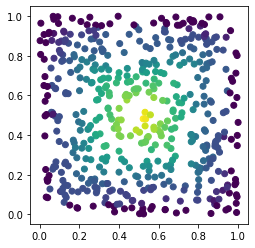

In [87]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(X[:,0], X[:,1], c=u)
ax.set_aspect('equal')
plt.show()